<a href="https://colab.research.google.com/github/RPGraciotti/BootCampAlura/blob/main/Modulo_2/Aula_6_Agrupando_dados_e_analisando_por_categoria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 6
Preparando conteúdo anterior: 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
from datetime import date

df = pd.read_csv("https://raw.githubusercontent.com/RPGraciotti/agendamento-hospitalar/main/dados/A160324189_28_143_208.csv", encoding = "ISO-8859-1",
                 skiprows = 3, sep = ";", skipfooter = 12,
                 thousands = ".", decimal = ",", engine = "python")
pd.options.display.float_format = "{:.2f}".format
use_col = df.mean().index.tolist()
use_col.insert(0, "Unidade da Federação")
use = df.loc[:,use_col]
use = use.set_index("Unidade da Federação")
use.sort_values(by = "Total") # crescente
total_ord = use.sort_values(by = "Total", ascending = False) # decrescente
total_ord = total_ord.drop("Total", axis = 1)
main_cols = total_ord.columns[6:]
total_ord = total_ord[main_cols]
total_ord = total_ord/1000000
total_ord.index = total_ord.index.str[3:] # Matar esse problema aqui de vez
ultimo_mes = total_ord.columns[-1]
gastos_ultimo_mes = total_ord[ultimo_mes]
gastos_prop_estado = gastos_ultimo_mes / gastos_ultimo_mes.sum()
tabelas_wiki = pd.read_html("https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_popula%C3%A7%C3%A3o")
dados_populacao_raw = tabelas_wiki[0]
dados_populacao_raw

def limpeza(df1, df2):
  """limpeza, tratamento e join de dados"""
  df1 = df1.dropna().copy()
  df1.columns = ["posicao", "uf", "populacao", "porc", "pais"]
  df1.loc[:,"populacao"] = pd.to_numeric(df1.loc[:,"populacao"].str.replace(" ",""))
  df1 = df1.loc[:,["populacao", "uf"]]
  df1 = df1.set_index("uf")
  df1.index = df1.index.str.strip()

  for i in df2.index:
    df1.index = df1.index.str.replace(f"{i} {i}", i)

  return df1.join(df2)

gastos_e_populacao_recente = limpeza(dados_populacao_raw, gastos_ultimo_mes)

def insere_gastos_e_gasto_por_habitante_para(todos_os_gastos: pd.DataFrame, dados: pd.DataFrame, mes: str): 
  # mes: str define que o tipo de mes só pode ser string
  # pd.DataFrame para definir que só pode ser DataFrame
  gastos_do_mes = todos_os_gastos.loc[:,mes]
  dados.loc[:, f"gastos_{mes}"] = gastos_do_mes * 1000000
  dados.loc[:, f"gasto_por_habitante_{mes}"] = dados.loc[:, f"gastos_{mes}"] / dados.loc[:, "populacao"]

mensal = total_ord.T

# criando dicionario

meses = {
    "Jan" : 1,
    "Fev" : 2,
    "Mar" : 3,
    "Abr" : 4,
    "Mai" : 5,
    "Jun" : 6,
    "Jul" : 7,
    "Ago" : 8,
    "Set" : 9,
    "Out" : 10,
    "Nov" : 11,
    "Dez" : 12
}

def para_dia(ano_mes: str):
  ano: int = int(ano_mes[:4])
  mes: str = ano_mes[5:]
  mes_numero: int = meses[mes]
  return date(ano, mes_numero, 1)

mensal.index = mensal.index.map(para_dia)

mensal_aberto = mensal.reset_index().melt(id_vars = ["index"], value_vars = mensal.columns)
mensal_aberto.columns = ["mes", "uf", "gasto"]

mensal_aberto.columns = ["dia_mes_ano", "uf", "gasto"]
mensal_aberto.loc[:,"dia_mes_ano"] = mensal_aberto.loc[:,"dia_mes_ano"].astype("datetime64")

mensal_aberto.loc[:,"mes"] = mensal_aberto.loc[:,"dia_mes_ano"].dt.month
mensal_aberto.loc[:,"ano"] = mensal_aberto.loc[:,"dia_mes_ano"].dt.year


inv_meses = {v: k for k, v in meses.items()} # aqui precisaremos fazer a conversão contrária do que foi feito antes, invertendo o dicionário
mensal_aberto.loc[:,"mes_str"] = mensal_aberto.loc[:,"mes"].map(inv_meses)
mensal_aberto.loc[:,"mes_str"] = pd.Categorical(mensal_aberto.loc[:,'mes_str'],["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"])

dias_por_mes = {
    1 : 31,
    2 : 28,
    3 : 31,
    4 : 30,
    5 : 31,
    6 : 30,
    7 : 31,
    8 : 31,
    9 : 30,
    10 : 31,
    11 : 30,
    12 : 31
}

mensal_aberto.loc[:, "gasto_diario"] = mensal_aberto.loc[:, "gasto"] / mensal_aberto.loc[:,"mes"].map(dias_por_mes)

In [2]:
mensal_aberto.head()

,dia_mes_ano,uf,gasto,mes,ano,mes_str,gasto_diario
0,2008-02-01,São Paulo,172.83,2,2008,Fev,6.17
1,2008-03-01,São Paulo,170.48,3,2008,Mar,5.50
2,2008-04-01,São Paulo,170.28,4,2008,Abr,5.68
3,2008-05-01,São Paulo,172.40,5,2008,Mai,5.56
4,2008-06-01,São Paulo,175.42,6,2008,Jun,5.85


In [3]:
estado_a_analisar = mensal_aberto.query("uf == 'São Paulo'")

estado_a_analisar.head()

,dia_mes_ano,uf,gasto,mes,ano,mes_str,gasto_diario
0,2008-02-01,São Paulo,172.83,2,2008,Fev,6.17
1,2008-03-01,São Paulo,170.48,3,2008,Mar,5.50
2,2008-04-01,São Paulo,170.28,4,2008,Abr,5.68
3,2008-05-01,São Paulo,172.40,5,2008,Mai,5.56
4,2008-06-01,São Paulo,175.42,6,2008,Jun,5.85


In [4]:
gastos_por_ano = estado_a_analisar.groupby("ano").sum()

In [5]:
gastos_por_ano.head()

,gasto,mes,gasto_diario
ano,,,
2008,1960.23,77,64.60
2009,2489.03,78,81.82
2010,2696.62,78,88.63
2011,2794.55,78,91.91
2012,2873.97,78,94.47


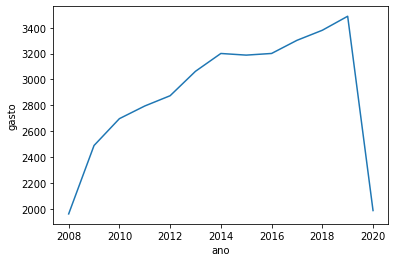

In [6]:
sns.lineplot(data = gastos_por_ano, x = gastos_por_ano.index, y = "gasto")
# arrumar limite

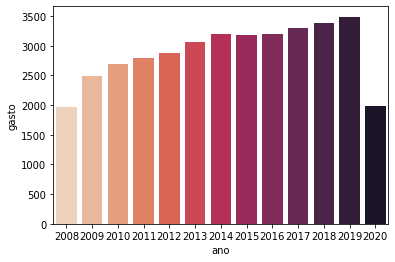

In [7]:
sns.barplot(data = gastos_por_ano, x = gastos_por_ano.index, y = "gasto", 
            palette = sns.color_palette("rocket_r", 13))

## Desafio 01 - Reordenar as cores pelo valor do eixo y:
"A cor passa uma mensagem nova ou reforça uma mensagem que queremos reforçar"

É possível indicar para o barplot colorir o eixo y passando ele como hue também, mas é necessário também passar o argumento "dodge = False" :


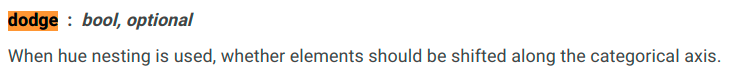

Importante notar que também que isso gera uma legenda "desnecessária", pois ela indicaria cada valor categórico separadamente, por isso escolhi suprimir a legenda.

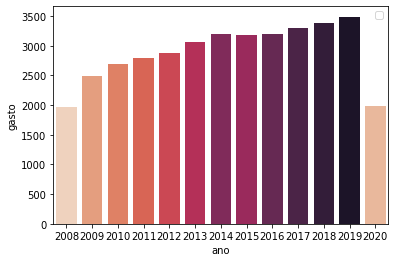

In [8]:
sns.barplot(data = gastos_por_ano, x = gastos_por_ano.index, y = "gasto", hue = "gasto", dodge = False, 
            palette = sns.color_palette("rocket_r", 13))
plt.legend("")
plt.show()

## Desafio 02 - Estudar a documentação do Seaborn: 

- https://seaborn.pydata.org/index.html (pagina inicial)
- https://seaborn.pydata.org/tutorial.html (tutorial com exemplos mais comuns)
- https://seaborn.pydata.org/api.html (API com referência para os agrupadores de tipos principais de gráficos)
- https://seaborn.pydata.org/generated/seaborn.barplot.html (exemplo de documentação sobre um tipo específico, no caso, barplot que usamos)

## Seguindo

In [9]:
gastos_por_ano.head()

,gasto,mes,gasto_diario
ano,,,
2008,1960.23,77,64.60
2009,2489.03,78,81.82
2010,2696.62,78,88.63
2011,2794.55,78,91.91
2012,2873.97,78,94.47


In [10]:
estados = ["São Paulo", "Minas Gerais", "Pernambuco"]
estados_por_ano = mensal_aberto.query("uf in @estados").groupby(["uf", "ano"]).sum().reset_index()

In [11]:
estados_por_ano.head()

,uf,ano,gasto,mes,gasto_diario
0,Minas Gerais,2008,894.35,77,29.44
1,Minas Gerais,2009,1149.14,78,37.77
2,Minas Gerais,2010,1217.49,78,40.03
3,Minas Gerais,2011,1315.02,78,43.24
4,Minas Gerais,2012,1408.35,78,46.29


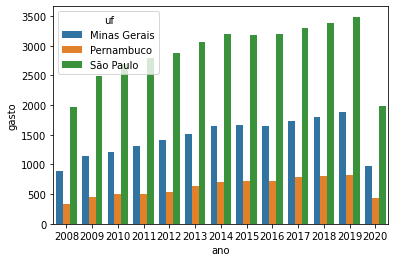

In [12]:
sns.barplot(data = estados_por_ano, x = "ano", y = "gasto", hue = "uf")

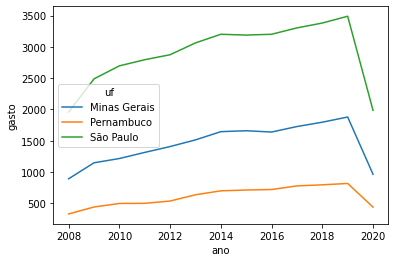

In [13]:
sns.lineplot(data = estados_por_ano, x = "ano", y = "gasto", hue = "uf")

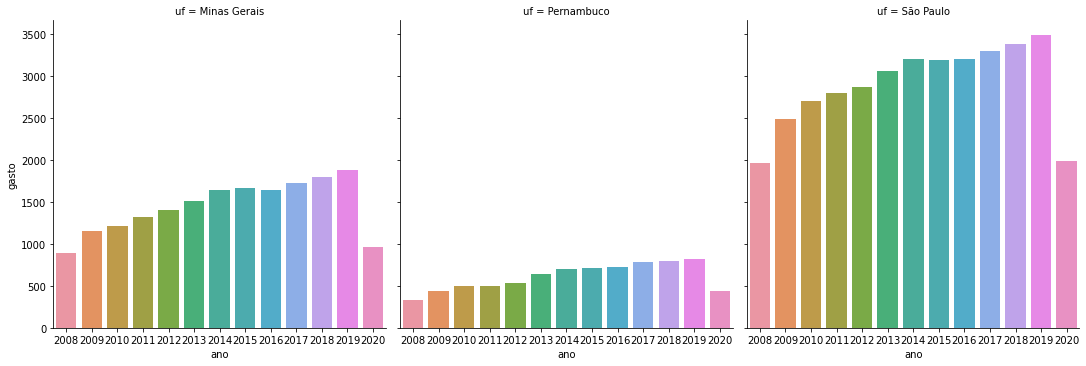

In [14]:
sns.catplot(data = estados_por_ano, x = "ano", y = "gasto", kind = "bar", col = "uf")

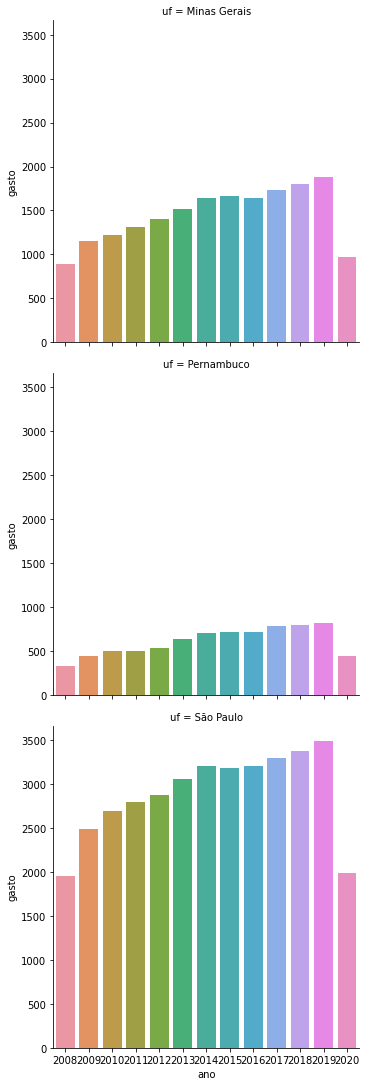

In [15]:
sns.catplot(data = estados_por_ano, x = "ano", y = "gasto", kind = "bar", row = "uf")

## Desafio 03 - Pensar e elaborar novos gráficos depois de estudar o seaborn, compartilhar com uma breve descrição no discord, para que outros colegas aprendam sobre o gráfico usado:

Para esse exercício, resolvi comparar dois estados de gastos semelhantes da mesma região, Minas Gerais e Rio de Janeiro. Escolhi trabalhar com boxplots no agrupador catplot, usando o eixo x como ano e y como gasto. Dessa forma, eu quero olhar para as distrubuições dos gastos por mês de cada ano, e também verificar se há valores muito discrepantes (outliers) em algum ano específico; e também comparar essa estimativa entre estados diferentes. Ressalto que é mais um exercício de treino de visualização de dados com diferentes combinações de parâmetros para conhecer mais a fundo o funcionamento do seaborn, sem que haja necessariamente uma hipótese ou uma pergunta prévia relevante.

In [16]:
estados_lista = ["Minas Gerais", "Rio de Janeiro"]
estados = mensal_aberto.query("uf in @estados_lista")
estados

,dia_mes_ano,uf,gasto,mes,ano,mes_str,gasto_diario
150,2008-02-01,Minas Gerais,70.30,2,2008,Fev,2.51
151,2008-03-01,Minas Gerais,79.12,3,2008,Mar,2.55
152,2008-04-01,Minas Gerais,79.05,4,2008,Abr,2.63
153,2008-05-01,Minas Gerais,79.27,5,2008,Mai,2.56
154,2008-06-01,Minas Gerais,79.61,6,2008,Jun,2.65
...,...,...,...,...,...,...,...
745,2020-03-01,Rio de Janeiro,73.59,3,2020,Mar,2.37
746,2020-04-01,Rio de Janeiro,68.16,4,2020,Abr,2.27
747,2020-05-01,Rio de Janeiro,86.28,5,2020,Mai,2.78
748,2020-06-01,Rio de Janeiro,77.60,6,2020,Jun,2.59


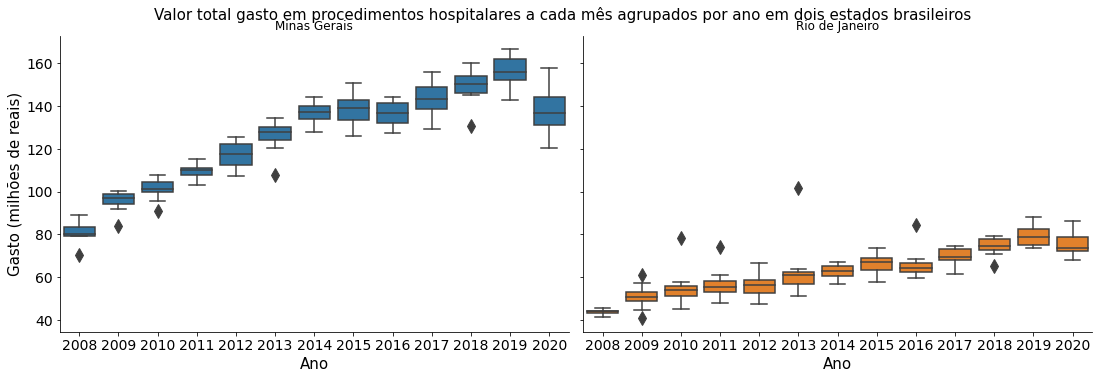

In [17]:
ax = sns.catplot(data = estados, kind = "box", x = "ano", y = "gasto", hue = "uf", 
            height = 5, aspect = 1.5, fliersize = 10, dodge = False, col = "uf")
ax.fig.subplots_adjust(top = 0.9)
ax.fig.suptitle("Valor total gasto em procedimentos hospitalares a cada mês agrupados por ano em dois estados brasileiros", 
          fontsize = 15)
ax.set_xlabels("Ano", fontsize = 15)
ax.set_ylabels("Gasto (milhões de reais)", fontsize = 15)
ax.fig.axes[0].set_title("Minas Gerais")
ax.fig.axes[1].set_title("Rio de Janeiro")
ax.fig.axes[0].tick_params(axis = "both", which = "major", labelsize = 14)
ax.fig.axes[1].tick_params(axis = "both", which = "major", labelsize = 14)

plt.show()

Nessa visualização relativamente simples, vemos que Minas Gerais costuma ter valores outliers sempre abaixo, nunca acima da distribuição, enquanto que no Rio de Janeiro, temos mais valores acima do que abaixo. Talvez no Rio de Janeiro tenham mais gastos excedentes nos meses de verão? Devido à grande quantidade de chuvas provocando deslizamentos, ou maiores casos de doenças? Podemos ver que no ano de 2013 houve o maior valor excedente no Rio de Janeiro, será que houve algum episódio de saúde pública mais intensa este ano? Perguntas que podem ser respondidas olhando esses dados mais a fundo.

## Desafio 04 - Baixe uma outra base de dados do tabnet e execute sua análise de forma similar a aula:

Para esse exercício eu escolhi trabalhar com o dado de óbitos, novamente, apenas para aplicação dos conceitos, sem que houvesse necessariamente alguma hipótese por trás. Utilizei a exata mesma query que usamos para chegar no atendidmento hospitalar, mas no valor eu indiquei "óbitos". Vamos ver o que descobrimos?

In [18]:
df = pd.read_csv("https://raw.githubusercontent.com/RPGraciotti/BootCampAlura/main/Data/A204040189_28_143_208.csv", encoding = "ISO-8859-1",
                 skiprows = 3, sep = ";", skipfooter = 12,
                 thousands = ".", decimal = ",", engine = "python")
pd.options.display.float_format = "{:.2f}".format
use_col = df.mean().index.tolist()
use_col.insert(0, "Unidade da Federação")
use = df.loc[:,use_col]
use = use.set_index("Unidade da Federação")
use.sort_values(by = "Total") # crescente
total_ord = use.sort_values(by = "Total", ascending = False) # decrescente
total_ord = total_ord.drop("Total", axis = 1)
main_cols = total_ord.columns[3:] # manter o mesmo ponto de partida do outro dataset
total_ord = total_ord[main_cols]
total_ord.index = total_ord.index.str[3:] # Matar esse problema aqui de vez

mensal_obitos = total_ord.T

# criando dicionario

meses = {
    "Jan" : 1,
    "Fev" : 2,
    "Mar" : 3,
    "Abr" : 4,
    "Mai" : 5,
    "Jun" : 6,
    "Jul" : 7,
    "Ago" : 8,
    "Set" : 9,
    "Out" : 10,
    "Nov" : 11,
    "Dez" : 12
}

def para_dia(ano_mes: str):
  ano: int = int(ano_mes[:4])
  mes: str = ano_mes[5:]
  mes_numero: int = meses[mes]
  return date(ano, mes_numero, 1)

mensal_obitos.index = mensal_obitos.index.map(para_dia)

mensal_aberto_obitos = mensal_obitos.reset_index().melt(id_vars = ["index"], value_vars = mensal_obitos.columns)
mensal_aberto_obitos.columns = ["mes", "uf", "obitos"]

mensal_aberto_obitos.columns = ["dia_mes_ano", "uf", "obitos"]
mensal_aberto_obitos.loc[:,"dia_mes_ano"] = mensal_aberto_obitos.loc[:,"dia_mes_ano"].astype("datetime64")

mensal_aberto_obitos.loc[:,"mes"] = mensal_aberto_obitos.loc[:,"dia_mes_ano"].dt.month
mensal_aberto_obitos.loc[:,"ano"] = mensal_aberto_obitos.loc[:,"dia_mes_ano"].dt.year

inv_meses = {v: k for k, v in meses.items()} # aqui precisaremos fazer a conversão contrária do que foi feito antes, invertendo o dicionário
mensal_aberto_obitos.loc[:,"mes_str"] = mensal_aberto_obitos.loc[:,"mes"].map(inv_meses)
mensal_aberto_obitos.loc[:,"mes_str"] = pd.Categorical(mensal_aberto_obitos.loc[:,'mes_str'],["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"])

dias_por_mes = {
    1 : 31,
    2 : 28,
    3 : 31,
    4 : 30,
    5 : 31,
    6 : 30,
    7 : 31,
    8 : 31,
    9 : 30,
    10 : 31,
    11 : 30,
    12 : 31
}



Podemos fazer uma análise simples de agrupamento como foi feito em aula e observar como cresceu o número total de óbitos, no estado de São Paulo

In [19]:
obitos_sp = mensal_aberto_obitos.query("uf == 'São Paulo'")
obitos_ano_sp = obitos_sp.groupby("ano").sum()
obitos_ano_sp

,obitos,mes
ano,,
2008,102839,78
2009,105225,78
2010,111090,78
2011,110655,78
2012,111740,78
2013,112820,78
2014,115523,78
2015,118264,78
2016,122550,78


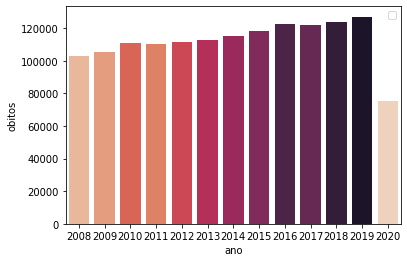

In [20]:
sns.barplot(data = obitos_ano_sp, x = obitos_ano_sp.index, y = "obitos", hue = "obitos", dodge = False, 
            palette = sns.color_palette("rocket_r", 13))
plt.legend("")
plt.show()

Podemos ver uma evolução do número de óbitos ao longo do tempo. 

**NOTA: Claro, vemos que no ano de 2020, tem muitos fatores envolvidos: por mais que saibamos que a pandemia de COVID19 está ocorrendo, lembre-se que 1) Em aula nós pesquisamos a partir do atendimento hospitalar, e não processamento, o que naturalmente leva a um "lag" no preenchimento desse dado e também que 2) a análise foi feita até Julho de 2020, ou seja, de qualquer forma, o ano de 2020 não está completo nem até o final, e nem os meses que estão presentes estão completos, por isso vemos essa queda.**

Somente a título de curiosidade, vou replicar exatamente a análise que fizemos em aula, comparando três estados:

In [21]:
estados = ["São Paulo", "Minas Gerais", "Pernambuco"]
obitos_estados_por_ano = mensal_aberto_obitos.query("uf in @estados").groupby(["uf", "ano"]).sum().reset_index()

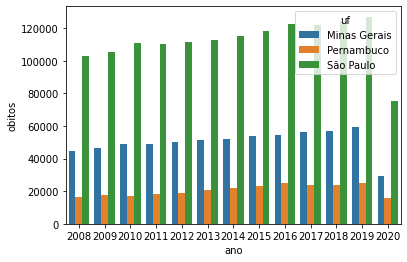

In [22]:
sns.barplot(data = obitos_estados_por_ano, x = "ano", y = "obitos", hue = "uf")

(0.0, 132693.65)

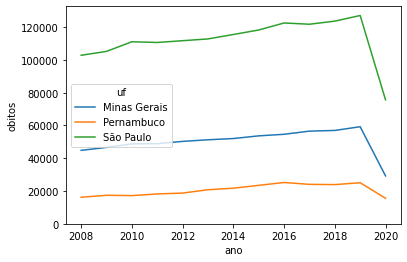

In [23]:
sns.lineplot(data = obitos_estados_por_ano, x = "ano", y = "obitos", hue = "uf")
plt.ylim(0)

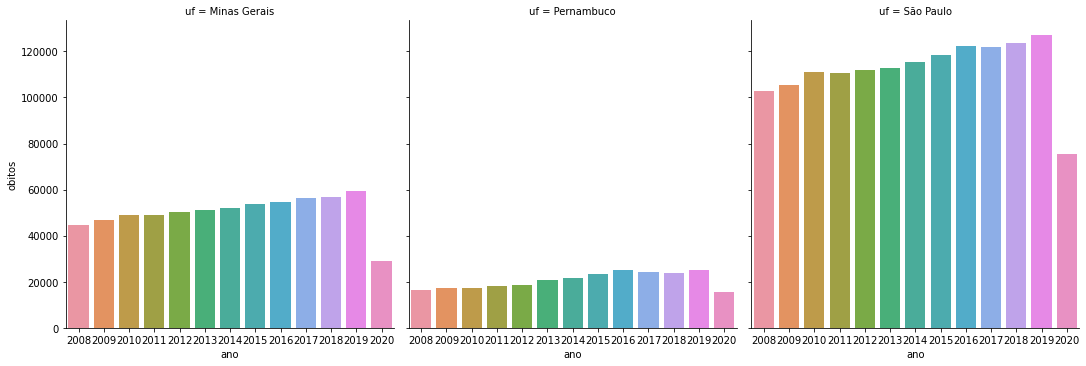

In [24]:
sns.catplot(data = obitos_estados_por_ano, x = "ano", y = "obitos", kind = "bar", col = "uf")

O Gui falou em aula que poderia ser interessante juntar esses dois dataframes. Podemos fazer isso com merge(), já que deixamos o dataset de óbitos com a mesma estrutura, apenas mudando o valor. Ao fazer o merge, só será adicionada a coluna com óbitos:

In [25]:
gasto_obitos_estados_ano = estados_por_ano.merge(obitos_estados_por_ano)
gasto_obitos_estados_ano.head()

,uf,ano,gasto,mes,gasto_diario,obitos
0,Minas Gerais,2009,1149.14,78,37.77,46611
1,Minas Gerais,2010,1217.49,78,40.03,48777
2,Minas Gerais,2011,1315.02,78,43.24,48888
3,Minas Gerais,2012,1408.35,78,46.29,50295
4,Minas Gerais,2013,1514.84,78,49.79,51278


A análise mais simples que podemos fazer com essa nova informação é nos perguntar, será que há uma relação entre o valor total gasto e o número de óbitos? Podemos responder isso com um scatterplot:

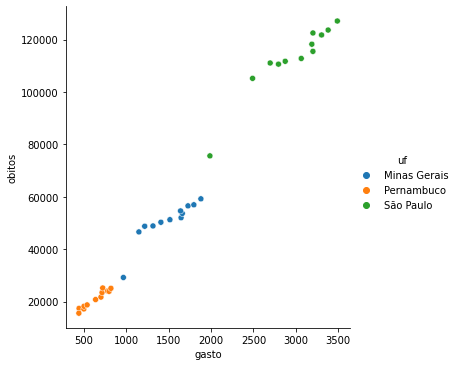

In [26]:
sns.relplot(data = gasto_obitos_estados_ano, x = "gasto", y = "obitos", kind = "scatter", hue = "uf")
plt.show()

Batendo o olho, parece haver uma relação do valor total com o número de óbitos.

**Nota: hum, será mesmo? O que devemos considerar aqui: o valor total aumenta, os óbitos aumentam. O tempo passa (cada ponto é um ano), os dois valores aumentam. O que mais aumenta conforme o tempo passa? A população total. O que São Paulo tem mais que Minas Gerais? E Minas Gerais mais que Pernambuco? População. Percebe que uma leitura muito crua desses dados não é informativa? O que acontece é que existem muitas outras variáveis para as quais nós não estamos controlando aqui nesse análise, de forma a não permitir muitas conclusões sobre os reais padrões aqui. Novamente, eu considerei esses exercícios mais sobre o treinamento dos tipos de visualizações, de manipulação dos conjuntos de dados, do que qualquer outra coisa. Certamente, análises bem mais refinadas responderiam de forma mais satisfatória a pergunta "será que há uma relação do valor total gasto em procedimentos hospitalares com o número de óbitos?"**